In [128]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [129]:
df = pd.concat([df, df_advertiser, df_keywords, df_search_tags], axis=1)


In [130]:
import torch
from torch_geometric.data import HeteroData

# Initialize graph
data = HeteroData()

# Node ID mappings
campaign_mapping = {}  # {campaign_id: index}
platform_mapping = {}  # {platform_id: index}
channel_mapping = {}  # {channel_id: index}
advertiser_mapping = {}  # {advertiser_word: index}
keywords_mapping = {}  # {keyword: index}
search_tags_mapping = {}  # {search_tag: index}



# Unique ID counters
campaign_counter = 0
platform_counter = 0
channel_counter = 0
advertiser_counter = 0
keywords_counter = 0
search_tags_counter = 0


In [131]:
def update_mapping(mapping, key, counter):
    """Ensure new inputs are added to the mapping with unique indices."""
    if key not in mapping:
        mapping[key] = counter
        counter += 1
    return mapping[key], counter


In [132]:
# Remove rows with any NaN values in any column
df = df.dropna()

## Campaign Nodes
### Each campaign treated as single entity across different rows

In [133]:
campaign_features = []  
campaign_counter = len(campaign_mapping)  # Start from existing mappings

for _, row in df[['campaign_index', 'no_of_days']].iterrows():
    campaign_id = row['campaign_index']
    features = row['no_of_days']

    campaign_id, campaign_counter = update_mapping(campaign_mapping, campaign_id, campaign_counter)
    campaign_features.append([features])  

data['campaign'].x = torch.tensor(campaign_features, dtype=torch.float)


## Platform Node

In [134]:
platform_data = df[['DV360', 'Facebook Ads', 'Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features

# Assign unique indices
platform_mapping = {'DV360': 0, 'Google Ads': 1, 'Facebook Ads': 2}


## Channel  Node

In [135]:
channel_data = df[['Display','Mobile','Search','Social','Video']].values
# Convert to tensor format
channel_features = torch.tensor(channel_data, dtype=torch.float)
data['channel'].x = channel_features

# Assign unique indices
channel_mapping = {'Display': 4,'Mobile': 0, 'Search': 1, 'Social': 2, 'Video': 3}


## Advertiser Node

In [136]:
advertiser_features = []  # Store advertiser embeddings
advertiser_mapping = {}  # Assign indices

# Fetching both the 'advertiser_name' and the embedding columns
advertiser_data = df[['advertiser_name'] + [f'advertiser_emb_{i}' for i in range(50)]]

# Iterate over rows of the DataFrame using iterrows
for _, row in advertiser_data.iterrows():
    advertiser_name = row['advertiser_name']  # Extract advertiser_name

    # Ensure advertiser_name is a scalar string, not a Series
    if isinstance(advertiser_name, pd.Series):
        advertiser_name = advertiser_name.iloc[0]  

    embedding = row[[f'advertiser_emb_{i}' for i in range(50)]].values  # Extract the 50D embedding
    
    if advertiser_name not in advertiser_mapping:
        advertiser_mapping[advertiser_name] = advertiser_counter
        advertiser_features.append(embedding)  # Store the embedding as a list
        advertiser_counter += 1

# Convert to tensor
data['advertiser'].x = torch.tensor(advertiser_features, dtype=torch.float)


## Keywords Node

In [137]:
keyword_features = []  
keywords_counter = len(keywords_mapping)  

for _, row in df[['keyword'] + [f'keyword_emb_{i}' for i in range(50)]].iterrows():
    keyword = row['keyword']
    embedding = row[[f'keyword_emb_{i}' for i in range(50)]].values  

    keyword, keywords_counter = update_mapping(keywords_mapping, keyword, keywords_counter)
    keyword_features.append(embedding)

data['keyword'].x = torch.tensor(keyword_features, dtype=torch.float)


## Creative Node

In [138]:
creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)

# Assign to creative nodes
data['creative'].x = creative_features  # Assign binary feature


## search tag Node

In [139]:
search_tag_features = []  
search_tags_counter = len(search_tags_mapping)  

for _, row in df[['search_tag'] + [f'search_tag_emb_{i}' for i in range(50)]].iterrows():
    search_tag = row['search_tag']
    embedding = row[[f'search_tag_emb_{i}' for i in range(50)]].values  

    search_tag, search_tags_counter = update_mapping(search_tags_mapping, search_tag, search_tags_counter)
    search_tag_features.append(embedding)

data['search_tag'].x = torch.tensor(search_tag_features, dtype=torch.float)


### ➤ Campaign → Platform Edges

In [140]:
campaign_platform_edges = []
campaign_platform_data = []


# Iterate over your dataset (df_filtered) and get campaign_id and platform
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    platform_name = row['platform']   # Get platform name
    campaign_platform_data.append([campaign_id, platform_name])  # Add to list

for campaign_id, platform_name in campaign_platform_data:  # (campaign_id, platform_name)
    campaign_idx = campaign_mapping[campaign_id]
    platform_idx = platform_mapping[platform_name]

    campaign_platform_edges.append([campaign_idx, platform_idx])

data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor(campaign_platform_edges, dtype=torch.long).T


### ➤ Campaign → Channel Edges

In [141]:
campaign_channel_edges = []
campaign_channel_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and channel
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    channel_name = row['channel_name']   # Get channel name
    campaign_channel_data.append([campaign_id, channel_name])  # Add to list

for campaign_id, channel_name in campaign_channel_data:  # (campaign_id, channel_name)
    campaign_idx = campaign_mapping[campaign_id]
    channel_idx = channel_mapping[channel_name]

    campaign_channel_edges.append([campaign_idx, channel_idx])

data['campaign', 'uses', 'channel'].edge_index = torch.tensor(campaign_channel_edges, dtype=torch.long).T


### ➤ Campaign → Advertiser Edges

In [142]:
campaign_advertiser_edges = []
campaign_advertiser_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and advertiser_name
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    advertiser_name = row['advertiser_name'].values[0]    # Get advertiser name
    campaign_advertiser_data.append([campaign_id, advertiser_name])  # Add to list

for campaign_id, advertiser_name in campaign_advertiser_data:  # (campaign_id, advertiser_name)
    campaign_idx = campaign_mapping[campaign_id]
    advertiser_idx = advertiser_mapping[advertiser_name]
    campaign_advertiser_edges.append([campaign_idx, advertiser_idx])

data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.tensor(campaign_advertiser_edges, dtype=torch.long).T


### ➤ Campaign → keywords Edges

In [143]:
campaign_keywords_edges = []
campaign_keywords_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and keywords
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    keywords = row['keywords']   # Get keywords name
    campaign_keywords_data.append([campaign_id, keywords])  # Add to list

for campaign_id, keywords in campaign_keywords_data:  # (campaign_id, keywords)
    campaign_idx = campaign_mapping[campaign_id]
    keywords_idx = keywords_mapping[keywords]
    campaign_keywords_edges.append([campaign_idx, keywords_idx])

data['campaign', 'belongs_to', 'keyword'].edge_index = torch.tensor(campaign_keywords_edges, dtype=torch.long).T


### ➤ Campaign → Creative Edges

In [144]:
campaign_creates_edges = []
campaign_creates_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and creative
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    creative = row['has_image']   # Get creative
    campaign_creates_data.append([campaign_id, creative])  # Add to list

for campaign_id, creative in campaign_creates_data:  # (campaign_id, creative)
    campaign_idx = campaign_mapping[campaign_id]

    campaign_creates_edges.append([campaign_idx, creative])

data['campaign', 'uses', 'creative'].edge_index = torch.tensor(campaign_creates_edges, dtype=torch.long).T

### ➤ Platform → Channel Edges

In [145]:
platform_channel_data = {
    'DV360': ['Display', 'Mobile', 'Search', 'Social', 'Video'],
    'Google Ads': ['Display', 'Mobile', 'Search', 'Social', 'Video'],
    'Facebook Ads': ['Display', 'Mobile', 'Search', 'Social', 'Video']
}

# List to store platform-channel edges
platform_channel_edges = []

# Iterate over the platform-channel relationships
for platform, channels in platform_channel_data.items():
    # Get the platform index
    platform_idx = platform_mapping[platform]
    
    # Iterate over the channels associated with this platform
    for channel in channels:
        # Get the channel index
        channel_idx = channel_mapping[channel]
        
        # Add the edge (platform -> channel)
        platform_channel_edges.append([platform_idx, channel_idx])

# Convert to tensor and assign to the graph
data['platform', 'supports', 'channel'].edge_index = torch.tensor(platform_channel_edges, dtype=torch.long).T


### ➤ Campaign → Search tag Edges

In [146]:
campaign_searchtag_edges = []
campaign_searchtag_data = []

# Iterate over your dataset (df_filtered) and get campaign_id and keywords
for index, row in df.iterrows():
    campaign_id = row['campaign_index']  # Get campaign_id
    search_tag = row['search_tags']   # Get keywords name
    campaign_searchtag_data.append([campaign_id, search_tag])  # Add to list

for campaign_id, keywords in campaign_searchtag_data:  # (campaign_id, keywords)
    campaign_idx = campaign_mapping[campaign_id]
    search_tag_idx = search_tags_mapping[search_tag]
    campaign_searchtag_edges.append([campaign_idx, search_tag_idx])

data['campaign', 'belongs_to', 'search_tags'].edge_index = torch.tensor(campaign_searchtag_edges, dtype=torch.long).T


### ➤ Platform → Keywords Edges

In [147]:
import json

# Load the data from the JSON file
with open('../Datasets/platform_keyword_data.json', 'r') as f:
    platform_keyword_data = json.load(f)

print(platform_keyword_data)  # You can now use this data in your program


{'Facebook Ads': ['huggie earrings', 'clip-on earrings', 'nature-inspired jewelry', 'dazzling jewelry', 'dangle earrings', 'boho jewelry', 'fashionable jewelry', 'elegant and modern jewelry', 'edwardian jewelry', 'vintage-inspired jewelry', 'costume jewelry', 'sophisticated jewelry', 'renaissance jewelry', 'summer jewelry', 'tassel earrings', 'initial jewelry', 'threader earrings', 'unique jewelry', 'cuff bracelets', 'brooches', 'personalized jewelry', 'beach jewelry', 'baroque jewelry', 'beaded bracelets', 'handmade jewelry', 'modern jewelry', 'art deco jewelry', 'statement rings', 'concert jewelry', 'stackable bracelets', 'drop earrings', 'stud earrings', 'retro jewelry', 'vibrant jewelry', 'victorian jewelry', 'casual jewelry', 'chic jewelry', 'everyday jewelry', 'affordable statement jewelry', 'zodiac jewelry', 'arm cuffs', 'fall jewelry', 'statement necklaces', 'body chains', 'gemstone jewelry', 'glamorous jewelry', 'exquisite jewelry', 'party jewelry', 'charm bracelets', 'bohemia

In [148]:
platform_keyword_edges = []

# Iterate over the platform-to-keyword relationships
for platform, keywords in platform_keyword_data.items():
    # Get the platform index
    platform_idx = platform_mapping[platform]

    # Iterate over the associated keywords
    for keyword in keywords:
        # Get the keyword index
        keyword_idx = keywords_mapping[keyword]

        # Add the edge (platform -> keyword)
        platform_keyword_edges.append([platform_idx, keyword_idx])

# Convert to tensor and assign to the graph
data['platform', 'supports', 'keyword'].edge_index = torch.tensor(platform_keyword_edges, dtype=torch.long).T


In [156]:
import torch

edge_list = []  # Store edges as (source, target) pairs

# Mapping counters to track indices of nodes
campaign_counter = len(campaign_mapping)
platform_counter = len(platform_mapping)
channel_counter = len(channel_mapping)
advertiser_counter = len(advertiser_mapping)
keyword_counter = len(keywords_mapping)
search_tag_counter = len(search_tags_mapping)

# Iterate through dataset and build edge connections
for _, row in df.iterrows():
    campaign_id = campaign_mapping[row['campaign_index']]
    
    # Platform edge
    if row['platform'] in platform_mapping:
        platform_id = platform_mapping[row['platform']] + campaign_counter  # Offset index
        edge_list.append([campaign_id, platform_id])
    
    # Channel edge
    if row['channel_name'] in channel_mapping:
        channel_id = channel_mapping[row['channel_name']] + campaign_counter + platform_counter
        edge_list.append([campaign_id, channel_id])
    
    # Advertiser edge
    advertiser_name = str(row['advertiser_name'])  # Fetch as a string
    if advertiser_name in advertiser_mapping:
        advertiser_id = advertiser_mapping[advertiser_name] + campaign_counter + platform_counter + channel_counter
        edge_list.append([campaign_id, advertiser_id])

    # Keyword edge
    if row['keyword'] in keywords_mapping:
        keyword_id = keywords_mapping[row['keyword']] + campaign_counter + platform_counter + channel_counter + advertiser_counter
        edge_list.append([campaign_id, keyword_id])
    
    # Search Tag edge
    if row['search_tag'] in search_tags_mapping:
        search_tag_id = search_tags_mapping[row['search_tag']] + campaign_counter + platform_counter + channel_counter + advertiser_counter + keyword_counter
        edge_list.append([campaign_id, search_tag_id])

    # Additional connections:
    # Platform → Channel
    if row['platform'] in platform_mapping and row['channel_name'] in channel_mapping:
        edge_list.append([platform_id, channel_id])

    # Platform → Keyword
    if row['platform'] in platform_mapping and row['keyword'] in keywords_mapping:
        edge_list.append([platform_id, keyword_id])

# Convert edge list to a tensor
edge_index = torch.tensor(edge_list, dtype=torch.long).T  # Transpose for PyG format

# Assign edge index to data
data.edge_index = edge_index


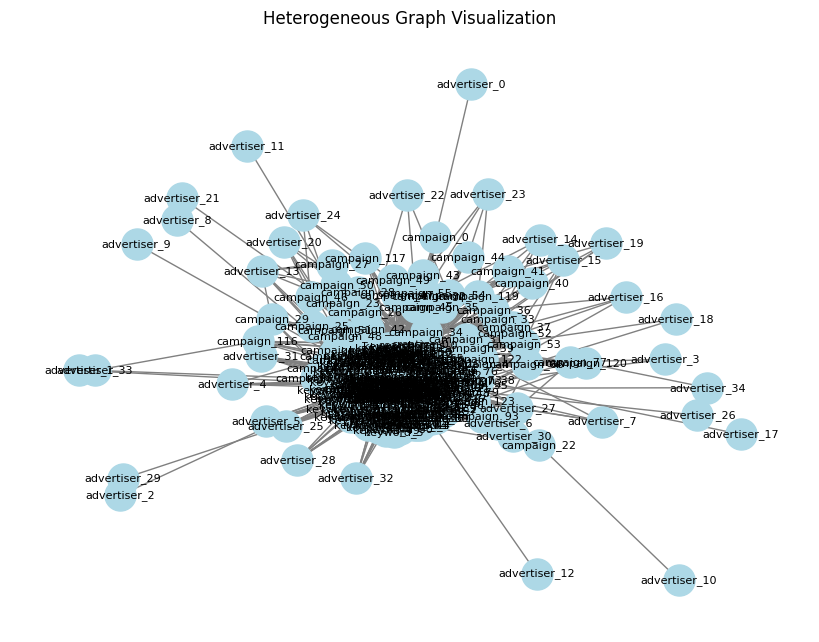

In [158]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert heterogeneous PyG graph to NetworkX for each edge type
G = nx.Graph()

# Loop through different edge types
for edge_type in data.edge_types:
    src_type, rel, dst_type = edge_type  # Extract node and relation names
    edge_index = data[edge_type].edge_index.numpy().T  # Get edges as NumPy array
    
    # Add edges to NetworkX graph
    for src, dst in edge_index:
        G.add_edge(f"{src_type}_{src}", f"{dst_type}_{dst}", relation=rel)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)

plt.title("Heterogeneous Graph Visualization")
plt.show()


In [159]:
print(df['engagement_level'].isna().sum())


0


In [160]:
# Count unique engagement categories per campaign
df_check = df.groupby('campaign_index')['engagement_level'].nunique()

# Find campaigns with more than one unique engagement category
conflicting_campaigns = df_check[df_check > 1]

# Display the number of such campaigns
print(f"Number of campaigns with multiple engagement categories: {len(conflicting_campaigns)}")

# Show detailed conflicts (optional)
if not conflicting_campaigns.empty:
    print("\nProblematic campaigns and their unique engagement levels:\n")
    for campaign_id in conflicting_campaigns.index:
        unique_levels = df[df['campaign_index'] == campaign_id]['engagement_level'].unique()
        print(f"Campaign {campaign_id} has engagement levels: {list(unique_levels)}")

Number of campaigns with multiple engagement categories: 111

Problematic campaigns and their unique engagement levels:

Campaign 1 has engagement levels: [2.0, 3.0, 1.0, 0.0]
Campaign 2 has engagement levels: [2.0, 1.0, 3.0, 0.0]
Campaign 3 has engagement levels: [1.0, 2.0, 3.0, 0.0]
Campaign 4 has engagement levels: [1.0, 2.0, 0.0, 3.0]
Campaign 5 has engagement levels: [2.0, 3.0]
Campaign 6 has engagement levels: [2.0, 0.0, 1.0, 3.0]
Campaign 8 has engagement levels: [1.0, 2.0]
Campaign 9 has engagement levels: [3.0, 1.0, 0.0, 2.0]
Campaign 10 has engagement levels: [2.0, 0.0, 1.0, 3.0]
Campaign 11 has engagement levels: [0.0, 3.0, 2.0, 1.0]
Campaign 12 has engagement levels: [3.0, 2.0, 1.0, 0.0]
Campaign 13 has engagement levels: [2.0, 1.0, 3.0, 0.0]
Campaign 14 has engagement levels: [2.0, 3.0, 1.0, 0.0]
Campaign 15 has engagement levels: [0.0, 2.0, 1.0, 3.0]
Campaign 16 has engagement levels: [2.0, 1.0, 0.0, 3.0]
Campaign 17 has engagement levels: [1.0, 2.0, 3.0, 0.0]
Campaign 18

In [161]:
# Remove rows where engagement_level is NaN
df = df.dropna(subset=['engagement_level'])

# Extract engagement levels for each unique campaign-feature instance (row-wise)
engagement_labels = torch.tensor(df['engagement_level'].values, dtype=torch.long)

# Assign each instance's engagement level as its target
data['campaign'].y = engagement_labels


In [ ]:
# # Assign the most frequent engagement level per campaign
# df_campaign_labels = df.groupby('campaign_index')['engagement_level'].agg(lambda x: x.mode()[0])

# # Convert to tensor
# engagement_labels = torch.tensor(df_campaign_labels.values, dtype=torch.long)

# # Assign to campaigns
# data['campaign'].y = engagement_labels


In [162]:
# print(f"Campaign features shape: {campaign_features.shape}")  # Should be (58930, feature_dim)
print(f"Campaign labels shape: {data['campaign'].y.shape}")  # Should match the number of campaign features

Campaign labels shape: torch.Size([58929])


In [163]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class EngagementGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EngagementGNN, self).__init__()
        
        # First GAT layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        
        # Second GAT layer
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels, heads=2, concat=True)
        
        # Final output layer
        self.out = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Activation function
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.out(x)
        return x


Epoch 1/100, Loss: 1.3827, Accuracy: 0.3200
Epoch 2/100, Loss: 1.3820, Accuracy: 0.3200
Epoch 3/100, Loss: 1.3813, Accuracy: 0.3200
Epoch 4/100, Loss: 1.3806, Accuracy: 0.3200
Epoch 5/100, Loss: 1.3799, Accuracy: 0.3200
Epoch 6/100, Loss: 1.3793, Accuracy: 0.3200
Epoch 7/100, Loss: 1.3786, Accuracy: 0.3200
Epoch 8/100, Loss: 1.3779, Accuracy: 0.3200
Epoch 9/100, Loss: 1.3772, Accuracy: 0.3200
Epoch 10/100, Loss: 1.3766, Accuracy: 0.3200
Epoch 11/100, Loss: 1.3759, Accuracy: 0.3200
Epoch 12/100, Loss: 1.3753, Accuracy: 0.3200
Epoch 13/100, Loss: 1.3746, Accuracy: 0.3200
Epoch 14/100, Loss: 1.3740, Accuracy: 0.3200
Epoch 15/100, Loss: 1.3733, Accuracy: 0.3200
Epoch 16/100, Loss: 1.3727, Accuracy: 0.3200
Epoch 17/100, Loss: 1.3721, Accuracy: 0.3200
Epoch 18/100, Loss: 1.3714, Accuracy: 0.3200
Epoch 19/100, Loss: 1.3708, Accuracy: 0.3200
Epoch 20/100, Loss: 1.3702, Accuracy: 0.3200
Epoch 21/100, Loss: 1.3696, Accuracy: 0.3200
Epoch 22/100, Loss: 1.3690, Accuracy: 0.3200
Epoch 23/100, Loss:

c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    983000
           1       0.32      0.93      0.48   1885500
           2       0.38      0.07      0.12   2200300
           3       0.00      0.00      0.00    824100

    accuracy                           0.32   5892900
   macro avg       0.17      0.25      0.15   5892900
weighted avg       0.24      0.32      0.20   5892900



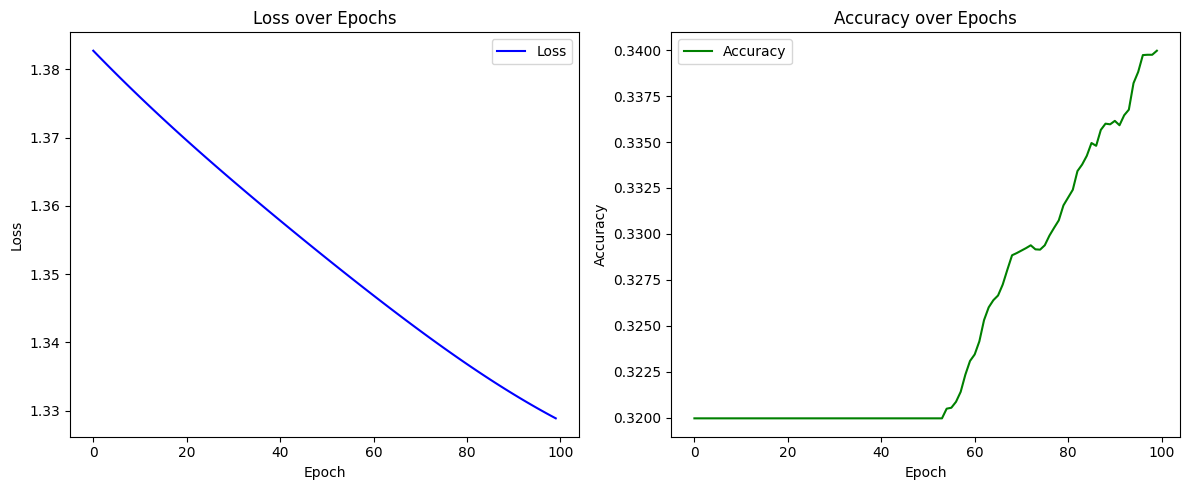

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch

def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, dim=1)  # Get the predicted class
    correct = (predicted == labels).sum()  # Count the number of correct predictions
    accuracy = correct / len(labels)  # Accuracy as a fraction
    return accuracy.item()  # Return as a scalar value

# Define training function
def train(model, data, optimizer, criterion, epochs=100):
    all_predictions = []  # List to store all predictions
    all_labels = []  # List to store all true labels
    loss_values = []  # List to store loss values
    accuracy_values = []  # List to store accuracy values
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        
        optimizer.zero_grad()  # Clear the gradients
        
        # Use node features for campaigns (or other node types as needed)
        campaign_features = data['campaign'].x  # Assuming 'campaign' nodes have features
        edge_index = data['campaign', 'belongs_to', 'advertiser'].edge_index  # Get edge index for the graph
        
        # Forward pass through the model with both node features and edge index
        out = model(campaign_features, edge_index)  # Pass both node features and edge index
        
        # Compute loss (assume labels are in 'campaign' node type)
        loss = criterion(out, data['campaign'].y)  # Assuming target labels are in data['campaign'].y

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights
        
        # Compute accuracy
        accuracy = compute_accuracy(out, data['campaign'].y)  # Assuming target is for 'campaign' nodes
        
        # Get predictions and labels
        predictions = torch.argmax(out, dim=1).cpu().numpy()
        labels = data['campaign'].y.cpu().numpy()
        
        # Accumulate the predictions and labels for the final report
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        
        # Store loss and accuracy for plotting
        loss_values.append(loss.item())
        accuracy_values.append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # After training ends, generate the final classification report
    print("\nFinal Classification Report:")
    report = classification_report(all_labels, all_predictions)
    print(report)

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_values, label='Loss', color='blue')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_values, label='Accuracy', color='green')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Define model
model = EngagementGNN(in_channels=data['campaign'].x.shape[1], 
                      hidden_channels=64, 
                      out_channels=4)  # 5 engagement levels

# Optimizer & Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
train(model, data, optimizer, criterion, epochs=100)


In [ ]:
import torch
import numpy as np

def process_user_input(user_input):
    """
    Convert user inputs into numerical tensors for prediction.
    
    Args:
    user_input (dict): Dictionary containing user-provided values.

    Returns:
    dict: A dictionary with tensors formatted for model input.
    """

    # 🔹 Retrieve Campaign Index (Ensure it's valid)
    campaign_idx = campaign_mapping.get(user_input['campaign'], None)
    if campaign_idx is None:
        raise KeyError(f"Campaign ID {user_input['campaign']} not found in mapping!")

    # 🔹 Campaign Features (MUST include campaign index + no_of_days)
    campaign_features = [campaign_idx, user_input['no_of_days']]  # FIXED

    # 🔹 One-hot encode platform
    platform_vector = [0, 0, 0]
    if user_input['platform'] in platform_mapping:
        platform_vector[platform_mapping[user_input['platform']]] = 1
    
    # 🔹 One-hot encode channel
    channel_vector = [0, 0, 0, 0, 0]
    if user_input['channel'] in channel_mapping:
        channel_vector[channel_mapping[user_input['channel']]] = 1
    
    # 🔹 Advertiser embedding (use existing if available, otherwise random)
    advertiser_vector = advertiser_mapping.get(
        user_input['advertiser_name'], np.random.rand(50)
    )

    # 🔹 Keyword embedding (use existing if available, otherwise random)
    keyword_vector = keywords_mapping.get(
        user_input['keyword'], np.random.rand(50)
    )

    # 🔹 Creative feature (binary)
    creative_vector = [user_input['has_image']]

    # 🔹 Search tag embedding (use existing if available, otherwise random)
    search_tag_vector = search_tags_mapping.get(
        user_input['search_tag'], np.random.rand(50)
    )

    # 🔹 Retrieve Node IDs for Edge Index
    platform_idx = platform_mapping.get(user_input['platform'], None)
    channel_idx = channel_mapping.get(user_input['channel'], None)
    advertiser_idx = advertiser_mapping.get(user_input['advertiser_name'], None)
    keyword_idx = keywords_mapping.get(user_input['keyword'], None)

    # Validate all indices before creating edge index
    if None in [platform_idx, channel_idx, advertiser_idx, keyword_idx]:
        raise KeyError("One or more input mappings were not found!")

    # 🔹 Construct Edge Index (Source -> Target)
    edge_index = torch.tensor([
        [campaign_idx, platform_idx],   # Campaign -> Platform
        [campaign_idx, channel_idx],    # Campaign -> Channel
        [campaign_idx, advertiser_idx], # Campaign -> Advertiser
        [campaign_idx, keyword_idx]     # Campaign -> Keyword
    ], dtype=torch.long).T  # Transpose for PyG format

    # Convert all inputs to tensors
    input_tensors = {
        'campaign': torch.tensor([campaign_features], dtype=torch.float),  # FIXED
        'platform': torch.tensor([platform_vector], dtype=torch.float),
        'channel': torch.tensor([channel_vector], dtype=torch.float),
        'advertiser': torch.tensor([advertiser_vector], dtype=torch.float),
        'keyword': torch.tensor([keyword_vector], dtype=torch.float),
        'creative': torch.tensor([creative_vector], dtype=torch.float),
        'search_tag': torch.tensor([search_tag_vector], dtype=torch.float),
        'edge_index': edge_index
    }

    return input_tensors


In [ ]:
# Example user input (from an API or user form)
user_input = {
    "campaign": 157,  # Categorical input
    "no_of_days": 10,  # Numeric input
    "platform": "Google Ads",  # One-hot encoded
    "channel": "Social",  # One-hot encoded
    "advertiser_name": "Nike",  # Mapped to embedding
    "keyword": "Sports",  # Mapped to embedding
    "has_image": 1,  # Binary feature
    "search_tag": "Athletic"  # Mapped to embedding
}

# Convert input to numeric tensors
formatted_inputs = process_user_input(user_input)

# Display formatted tensors
for key, value in formatted_inputs.items():
    print(f"{key}: {value.shape}")


platform: torch.Size([1, 3])
channel: torch.Size([1, 5])
advertiser: torch.Size([50])
keyword: torch.Size([50])
creative: torch.Size([1])
search_tag: torch.Size([50])
edge_index: torch.Size([2, 4])


In [181]:
print("Campaign Mapping:", campaign_mapping)
print("Campaign ID from user:", user_input['campaign'])
print("Mapped Campaign Index:", campaign_idx)


Campaign Mapping: {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 9.0: 7, 10.0: 8, 11.0: 9, 13.0: 10, 12.0: 11, 14.0: 12, 15.0: 13, 16.0: 14, 17.0: 15, 18.0: 16, 19.0: 17, 20.0: 18, 21.0: 19, 22.0: 20, 23.0: 21, 24.0: 22, 26.0: 23, 28.0: 24, 30.0: 25, 31.0: 26, 32.0: 27, 33.0: 28, 34.0: 29, 35.0: 30, 36.0: 31, 38.0: 32, 39.0: 33, 40.0: 34, 41.0: 35, 42.0: 36, 43.0: 37, 45.0: 38, 46.0: 39, 7.0: 40, 48.0: 41, 49.0: 42, 51.0: 43, 54.0: 44, 55.0: 45, 56.0: 46, 57.0: 47, 58.0: 48, 59.0: 49, 61.0: 50, 62.0: 51, 60.0: 52, 8.0: 53, 63.0: 54, 64.0: 55, 65.0: 56, 66.0: 57, 67.0: 58, 68.0: 59, 69.0: 60, 70.0: 61, 71.0: 62, 72.0: 63, 73.0: 64, 74.0: 65, 75.0: 66, 76.0: 67, 77.0: 68, 78.0: 69, 79.0: 70, 80.0: 71, 81.0: 72, 82.0: 73, 83.0: 74, 84.0: 75, 85.0: 76, 86.0: 77, 87.0: 78, 88.0: 79, 89.0: 80, 90.0: 81, 91.0: 82, 92.0: 83, 93.0: 84, 94.0: 85, 95.0: 86, 96.0: 87, 97.0: 88, 98.0: 89, 99.0: 90, 100.0: 91, 101.0: 92, 102.0: 93, 103.0: 94, 104.0: 95, 105.0: 96, 106.0: 97, 107.0: 98, 108

In [182]:
print("Platform Mapping:", platform_mapping)
print("User Platform:", user_input['platform'])
print("Mapped Platform Index:", platform_idx)

print("Channel Mapping:", channel_mapping)
print("User Channel:", user_input['channel'])
print("Mapped Channel Index:", channel_idx)


Platform Mapping: {'DV360': 0, 'Google Ads': 1, 'Facebook Ads': 2}
User Platform: Google Ads
Mapped Platform Index: 1
Channel Mapping: {'Display': 4, 'Mobile': 0, 'Search': 1, 'Social': 2, 'Video': 3}
User Channel: Social
Mapped Channel Index: 3


In [184]:
print("Edge Index Tensor:\n", edge_index)


Edge Index Tensor:
 [[  2 112]
 [  2   4]
 [  2  46]
 [  2  35]
 [  2  52]
 [  2  99]
 [  2  18]
 [  2  17]
 [  2  44]
 [  2  34]
 [  2  91]
 [  2  95]
 [  2  70]
 [  2  33]
 [  2  55]
 [  2 109]
 [  2  72]
 [  2  48]
 [  2  16]
 [  2  53]
 [  2 105]
 [  2  38]
 [  2 115]
 [  2   1]
 [  2 101]
 [  2  23]
 [  2  85]
 [  2  10]
 [  2  67]
 [  2  94]
 [  2  26]
 [  2  37]
 [  2  81]
 [  2  39]
 [  2  56]
 [  2 103]
 [  2  32]
 [  2  62]
 [  2  65]
 [  2  77]
 [  2  82]
 [  2  47]
 [  2  19]
 [  2 117]
 [  2  41]
 [  2 102]
 [  2  63]
 [  2  22]
 [  2  27]
 [  2   5]
 [  2  73]
 [  2   3]
 [  2  88]
 [  2  25]
 [  2 114]
 [  2   0]
 [  2  87]
 [  2  64]
 [  2  98]
 [  2  89]
 [  2  45]
 [  2  74]
 [  2  36]
 [  2 100]
 [  2  28]
 [  2   9]
 [  2 106]
 [  2  90]
 [  2  57]
 [  2  21]
 [  2 110]
 [  2  78]
 [  2  96]
 [  2  58]
 [  2 108]
 [  2 111]
 [  2  20]
 [  2  14]
 [  2  42]
 [  2   2]
 [  2  29]
 [  2  92]
 [  2  54]
 [  2   8]
 [  2  66]
 [  2   7]
 [  2  93]
 [  2  49]
 [  2  13]
 

In [183]:
import matplotlib
print(matplotlib.__version__)


3.9.1


In [179]:
def predict_engagement(model, input_data):
    """
    Predict engagement level using the trained model.
    
    Args:
    model (torch.nn.Module): Trained GNN model.
    input_data (dict): Dictionary containing tensors of user input features.

    Returns:
    torch.Tensor: Predicted engagement level.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients
        prediction = model(input_data['campaign'], input_data['edge_index'])  # Pass edge_index

    return prediction

In [180]:
# Assuming 'gnn_model' is your trained GNN model
prediction = predict_engagement(model, formatted_inputs)

print("Predicted Engagement Level:", prediction.item())


KeyError: 'campaign'